In [1]:
import numpy as np
from xrdc import xrdutils as xdu
from xrdc import simulation
from xrdc import datasets as xd
import matplotlib.pyplot as plt

from siamese_xrd import train, datasets, utils

def sample_peak_intensity():
    return np.random.uniform()

In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [993]:
from scipy.ndimage.filters import gaussian_filter as gf

In [3]:
# FCC Ni definition
lparam_Ni = 3.52
s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(lparam_Ni), ["Ni"],
                                 [[0, 0, 0]])
s

Structure Summary
Lattice
    abc : 3.52 3.52 3.52
 angles : 90.0 90.0 90.0
 volume : 43.614208
      A : 3.52 0.0 0.0
      B : 0.0 3.52 0.0
      C : 0.0 0.0 3.52
PeriodicSite: Ni (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ni (0.0000, 1.7600, 1.7600) [0.0000, 0.5000, 0.5000]
PeriodicSite: Ni (1.7600, 0.0000, 1.7600) [0.5000, 0.0000, 0.5000]
PeriodicSite: Ni (1.7600, 1.7600, 0.0000) [0.5000, 0.5000, 0.0000]

In [4]:
gen = XRDCalculator("CuKa")
# gen = XRDCalculator(1.54)
pat = gen.get_pattern(s)
xdu.to_q(pat.x), pat.y

(array([3.09170346, 3.56999165, 5.04873061]),
 array([100.        ,  46.36686035,  26.67333336]))

Define the same structure directly from lattice vectors and unit cell

In [5]:
lat = Lattice(lparam_Ni * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
fcc_basis = np.array(((0, 0, 0), (.5, .5, 0), (.5, 0, .5), (0, .5, .5)))
struct = Structure(lat, ["Ni"] * len(fcc_basis), fcc_basis)

pat = gen.get_pattern(struct)
q, i = xdu.to_q(pat.x), pat.y

In [6]:
def xrd_from_geo(lattice, basis, species):
    lat = Lattice(lattice)
    struct = Structure(lat, species, basis)
    
    pat = gen.get_pattern(struct)
    return xdu.to_q(pat.x), pat.y

In [7]:
def distort_Ni(relative_c, common_scale = 1.):
    return xrd_from_geo((lparam_Ni * common_scale) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, relative_c]]), fcc_basis, ["Ni"] * 4)

In [8]:
def Ni_cubic_to_tetra(N, c_start, c_end, sigma = .01):
    """
    """
    cs =  np.linspace(c_start, c_end, N)
    res = []
    ordinal = []
    for c in cs:
        q, i = distort_Ni(c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

def Ni_cubic_scale(N, s_start, s_end, sigma = .01):
    """
    """
    ss =  np.linspace(s_start, s_end, N)
    res = []
    ordinal = []
    for c in ss:
        q, i = distort_Ni(1, c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

In [9]:
#TODO refactor

def Ni_tetra_random(N, cmin, cmax, scalemin, scalemax, sigma = .01):
    """
    """
    cs = cmin + np.random.uniform(size = N) * (cmax - cmin)
    scales = scalemin + np.random.uniform(size = N) * (scalemax - scalemin)
    res = []
    ordinal = []
    for c, s in zip(cs, scales):
        q, i = distort_Ni(c, common_scale=s)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

def Ni_cubic_random(N, scalemin, scalemax, sigma = .01):
    """
    """
    scales = scalemin + np.random.uniform(size = N) * (scalemax - scalemin)
    res = []
    ordinal = []
    for c in scales:
        q, i = distort_Ni(1, c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

In [10]:
N = 4000

In [11]:
# _, Ni_tetra_rsample = Ni_tetra_random(N, .66, 1.5, .66, 1.5)

# Ni_tetra_rsample_y = np.zeros(N)

_, Ni_tetra_rsample = Ni_tetra_random(N, .9, 1.2, .99, 1.01)

Ni_tetra_rsample_y = np.zeros(N)

In [12]:
# _, Ni_cubic_rsample = Ni_cubic_random(N, .66, 1.5)

# Ni_cubic_rsample_y = np.ones(N)

_, Ni_cubic_rsample = Ni_cubic_random(N, .99, 1.01)

Ni_cubic_rsample_y = np.ones(N)

In [13]:
from sklearn.model_selection import train_test_split

In [866]:
reload(xdu)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [14]:
#X = np.log(1 + np.vstack((Ni_tetra_rsample, Ni_cubic_rsample)))
X = np.vstack((Ni_tetra_rsample, Ni_cubic_rsample))

Y = np.hstack((Ni_tetra_rsample_y, Ni_cubic_rsample_y))

#XX, YY = xdu.standardize_input(np.log(1 + X), Y)

In [15]:
XX, YY, _ = xdu.mk_simdata(X, 1, .8, 1.2, xdu.q_grid, y = Y, scale_type = 'scale',\
        q_dim = 150, peak_height = True, q_jitter_magnitude = None)

scale type: scale
q jitter: None
peak height variation True


In [468]:
(Y[:, None] == YY).all()

True

In [16]:
XXtrain, XXtest, YYtrain, YYtest = train_test_split(XX, YY, train_size = .8)

In [17]:
prefix = 'cubic_tetra_simulated_.9_1.2_3_peakheight_15'
xdu.write_train_test("data/{}/".format(prefix), XXtrain, YYtrain, XXtest, YYtest)

In [20]:
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = 2, epochs = 400)

  0%|          | 0/80000 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 80000/80000 [16:19<00:00, 81.66it/s, epoch=399, train_loss=0.00384, val_loss=0.00464] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-cubic_tetra_simulated_.9_1.2_3_peakheight_15-*


In [19]:
rm -r ./tmp/siamese-constrastive_1d-XRD-cubic_tetra_simulated_.9_1.2_3_peakheight_15-gif

In [21]:
from xrdc import visualization as vis

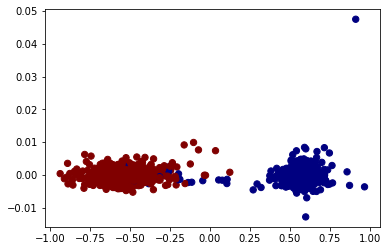

In [22]:
X, ytrue = utils.get_embedding(net, original_test_loader)

pca, Xpca = vis.do_pca(X)
plt.scatter(*(Xpca.T), c = ytrue, s = 40, cmap = 'jet')

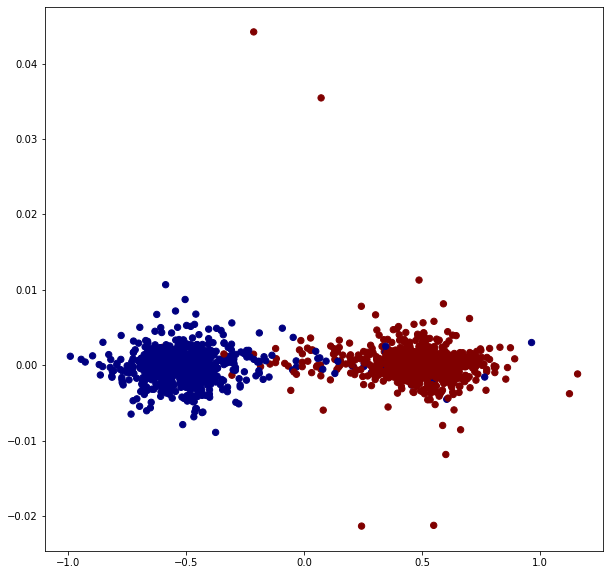

In [483]:
X, ytrue = utils.get_embedding(net, original_test_loader)

pca, Xpca = vis.do_pca(X)
plt.scatter(*(Xpca.T), c = ytrue, s = 40, cmap = 'jet')

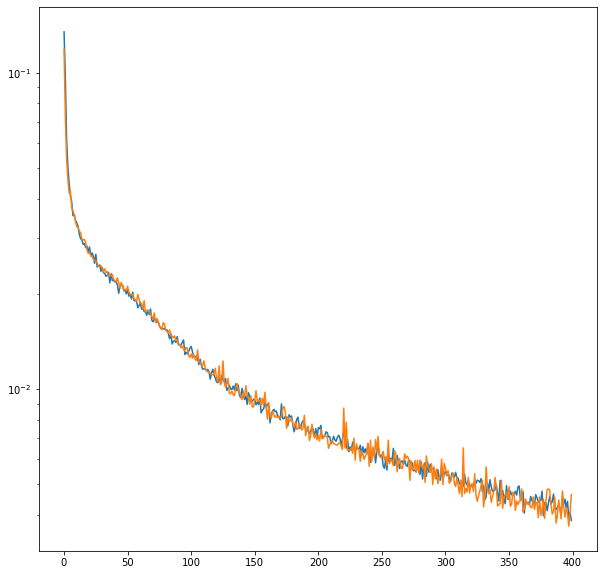

In [86]:
import matplotlib.pyplot as plt
plt.semilogy()
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

In [116]:
qqq = np.repeat(xdu.q_grid, N).reshape(len(xdu.q_grid), N).T

In [120]:
tmp = Ni_cubic_rsample[np.argsort((qqq * Ni_cubic_rsample).sum(axis = 1))]

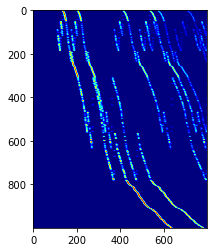

In [123]:
plt.imshow(np.log(1 + tmp), cmap = 'jet')

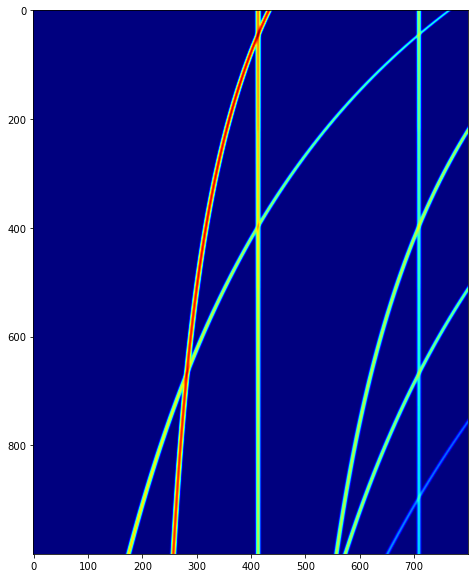

In [12]:
plt.rcParams["figure.figsize"]=(10, 10)

Ni_scan_peaks, Ni_scan = Ni_cubic_to_tetra(1000, .67, 1.5)

plt.imshow(np.log(Ni_scan + 1), cmap = 'jet')

In [170]:
Ni_cub_peaks, Ni_cub_scan = Ni_cubic_scale(1000, .67, 1.5)

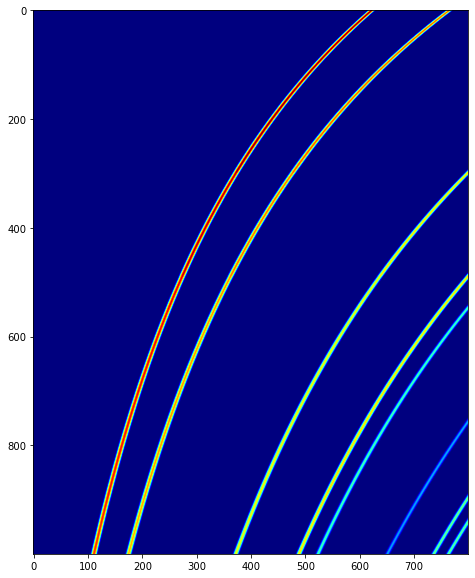

In [173]:
plt.imshow(np.log(Ni_cub_scan + 1), cmap = 'jet')

In [1111]:
import numpy as np, cv2
orig = Ni_scan[300:600]
vis = (np.log((1 + orig)) * 40).astype('uint8')
img = gray = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

edges = cv2.Canny(gray,50,150,apertureSize = 3)

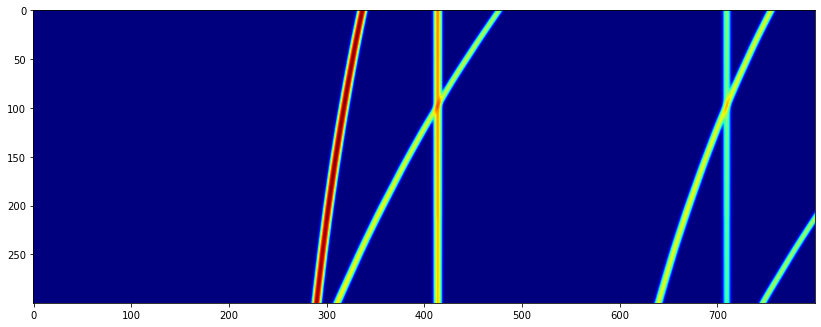

In [1112]:
plt.imshow(np.log(1 + orig), cmap = 'jet')
#plt.imshow(np.log(1 + edges))

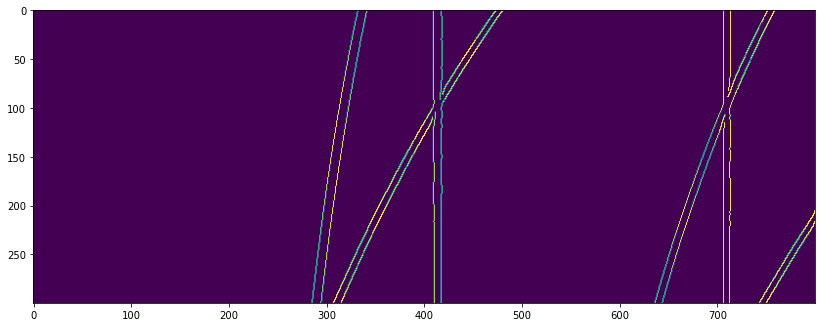

In [987]:
plt.imshow(edges)

In [265]:
lines = cv2.HoughLines(edges,1,np.pi/45,70)
for row in lines:
    for rho,theta in row:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

In [266]:
from xrdc import grid_data

lines_normed = (lines.squeeze() / lines.squeeze().mean(axis = 0))

lgroups = grid_data.group_by_coord(lines_normed, n_cluster=6)

lines_merged = []
for i in np.unique(lgroups):
    lines_merged.append(lines.squeeze()[lgroups == i].mean(axis = 0))
lines_merged = np.vstack(lines_merged)
assert lgroups.max() == 5

In [382]:
np.round(1.8)

2.0

In [383]:
round(1.8)

2

In [ ]:
np.count_nonzero

In [973]:
import numpy as np

def hough_line(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height))     # max_dist
    print(diag_len)
    diag_len = int(diag_len)
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    x_idxs, y_idxs = np.nonzero(img)    # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = int(np.round(x * cos_t[t_idx] + y * sin_t[t_idx])) + diag_len
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def hough_line_2(img):
    """
    vectorized implementation
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height))     # max_dist
    diag_len = int(diag_len)
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    x_idxs, y_idxs = np.nonzero(img)    # (row, col) indexes to edges


    for t_idx in range(num_thetas):
        # Calculate rho. diag_len is added for a positive index
        t = thetas[t_idx]
        rho = (np.round(x_idxs * cos_t[t_idx] + y_idxs * sin_t[t_idx])).astype(int) + diag_len
        np.add.at(accumulator, (rho, t_idx), 1)

    return accumulator, thetas, rhos

In [444]:
np.clip?

In [915]:
tmp = np.zeros((10, 20))

In [916]:
tmp[0, 1] = 10

In [917]:
np.nonzero(tmp)

(array([0]), array([1]))

In [967]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

# def find_closest(A, target, xx = None):
#     #A must be sorted
#     idx = A.searchsorted(target)
    
#     mask = np.logical_and(idx >= 1, idx <= len(A) - 1)
#     idx = idx[mask]
#     if xx is not None:
#         xx = xx[idx]
#     #idx = np.clip(idx, 1, len(A)-1)
#     left = A[idx-1]
#     right = A[idx]
#     idx -= target - left < right - target
#     if xx is not None:
#         return xx, idx
#     return idx

def hough_curve(img, a_min = -.02, a_max = .02, b_min = -2., b_max = 2,
                                      c_min = 0, c_max = 600, NN = 200):
    # Rho and Theta ranges
    aa = np.arange(a_min, a_max, (a_max - a_min) / NN)
    num_a = len(aa)
    bb = np.arange(b_min, b_max, (b_max - b_min) / NN)
    num_b = len(bb)
    
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height))     # max_dist

    cc = np.arange(c_min, c_max)
    num_c = len(cc)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((num_a, num_b, num_c), dtype=np.uint64)
    x_idxs, y_idxs = np.nonzero(img)    # (row, col) indexes to edges

#     # Vote in the hough accumulator
    for a_idx in range(num_a):
        a = aa[a_idx]
        for b_idx in range(num_b):
            b = bb[b_idx]
            c_exact = y_idxs - a * x_idxs**2 - b * x_idxs
            c_grid_idx = find_closest(cc, c_exact)
            
#             c_grid_idx = np.round(c_exact - c_min).astype(int)
#             mask = ((c_grid_idx <= c_max - 1) & (c_grid_idx >= c_min))
#             c_grid_idx = c_grid_idx[mask] + c_min
            
            np.add.at(accumulator, (a_idx, b_idx, c_grid_idx), 1)

            #accumulator[a_idx, b_idx, c_grid_idx] += 1
            
    I, K, L = accumulator.shape
    accumulator[0, :, :] = 0
    accumulator[:, 0, :] = 0
    accumulator[:, :, 0] = 0
    accumulator[I - 1, :, :] = 0
    accumulator[:, K - 1, :] = 0
    accumulator[:, :, L - 1] = 0
    return accumulator, aa, bb, cc

# def hough_curve(img):
#     # Rho and Theta ranges
#     thetas = np.deg2rad(np.arange(-90.0, 90.0))
#     width, height = img.shape
#     diag_len = np.ceil(np.sqrt(width * width + height * height))     # max_dist
#     print(diag_len)
#     diag_len = int(diag_len)
#     rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
    
#     #alphas = np.arange(0, .5, .05)
#     alphas = np.array([0])
#     num_alphas = len(alphas)

#     # Cache some resuable values
#     cos_t = np.cos(thetas)
#     sin_t = np.sin(thetas)
#     num_thetas = len(thetas)

#     # Hough accumulator array of theta vs rho
#     accumulator = np.zeros((2 * diag_len, num_thetas, num_alphas), dtype=np.uint64)
#     y_idxs, x_idxs = np.nonzero(img)    # (row, col) indexes to edges

#     # Vote in the hough accumulator
#     for i in range(len(x_idxs)):
#         x_p = x_idxs[i]
#         y_p = y_idxs[i]
#         for alpha_idx in range(len(alphas)):
#             alpha = alphas[alpha_idx]

#             for t_idx in range(num_thetas):
# #                 x0 = rho * cos_t[t_idx]
# #                 y0 = rho * sin_t[t_idx]
#                 DD = (x - rho * )
#                 b = (-1 + np.sqrt(1 + 4 * D * alpha**2)) / (2 * alpha**2)
                
#                 r_p = np.sqrt(x_p**2 + y_p**2)
                
#                 rho = r_p * sin_t[t_idx] - alpha * (r_p * cos_t[t_idx])**2
#                 rho = round(rho) + diag_len

                
                
# #                 alpha = (r_p * sin_t[t_idx] - rho) / ((r_p * cos_t[t_idx])**2)
# #                 alpha = round(alpha, 1)
                
# #                 alpha_idx = np.argmin(np.abs(alphas - alpha))

# #                 delta_d = alpha * ((x_p - x0)**2 + (y_p - y0)**2)
# #                 delta_x = sin_t[t_idx] * delta_d
# #                 delta_y = cos_t[t_idx] * delta_d

# #                 x = x_p - delta_x
# #                 y = y_p - delta_y



#                 # Calculate rho. diag_len is added for a positive index
#                 #rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len


#                 accumulator[rho, t_idx, alpha_idx] += 1

#     return accumulator, thetas, rhos, alphas

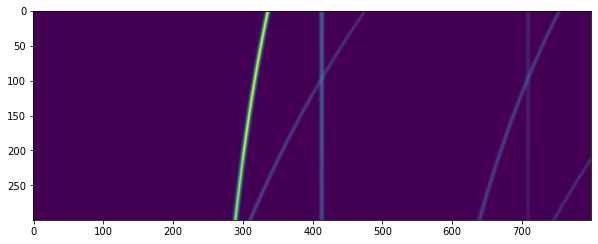

In [194]:
plt.imshow(orig)

In [426]:
one_line = cv2.line(np.zeros_like(img), (x1,y1),(x2,y2),(0,0,255),2).sum(axis = 2)

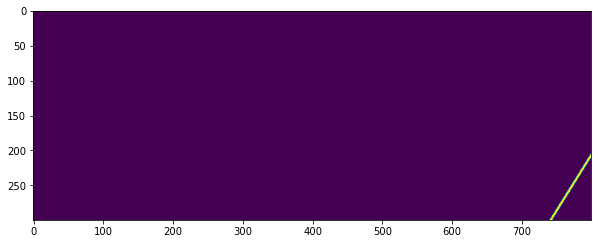

In [427]:
plt.imshow(one_line)

In [415]:
#accumulator, thetas, rhos = hough_line(one_line)
accumulator_l, thetas_l, rhos_l = hough_line(one_line)

accumulator_l2, thetas_l, rhos_l = hough_line_2(one_line)

(accumulator_l == accumulator_l2).all()

855.0
855.0


True

In [418]:
%timeit -r 1 -n 1 hough_line(one_line)

855.0
1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


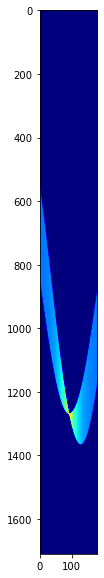

In [403]:
plt.imshow(np.log(1 + accumulator_l), cmap  = 'jet')

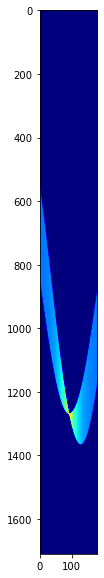

In [404]:
plt.imshow(np.log(1 + accumulator_l2), cmap  = 'jet')

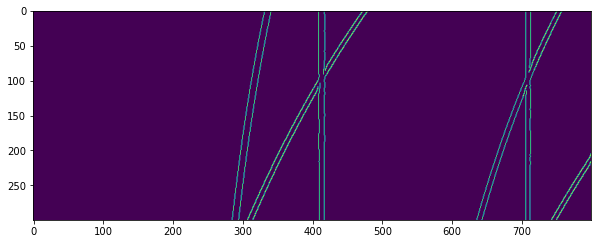

In [512]:
plt.imshow(edges)

855.0


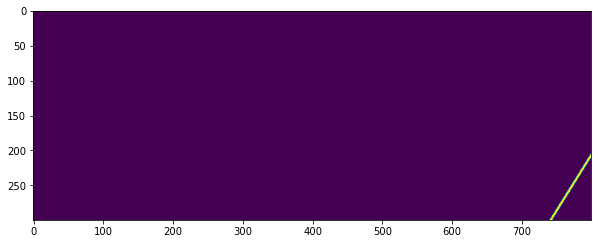

In [437]:
accumulator, aa, bb, cc = hough_curve(one_line)
plt.imshow(one_line)

In [949]:
def draw_parab(a, b, c, img):
    N, M = img.shape
    xx, yy = np.arange(N), np.arange(M)
    y_select = find_closest(yy, a * xx**2 + b * xx + c)
    img[xx, y_select] += 1
    return img

## 3D Hough transform of parabola:

(-0.0010000000000001154, -0.09999999999999831, 400)

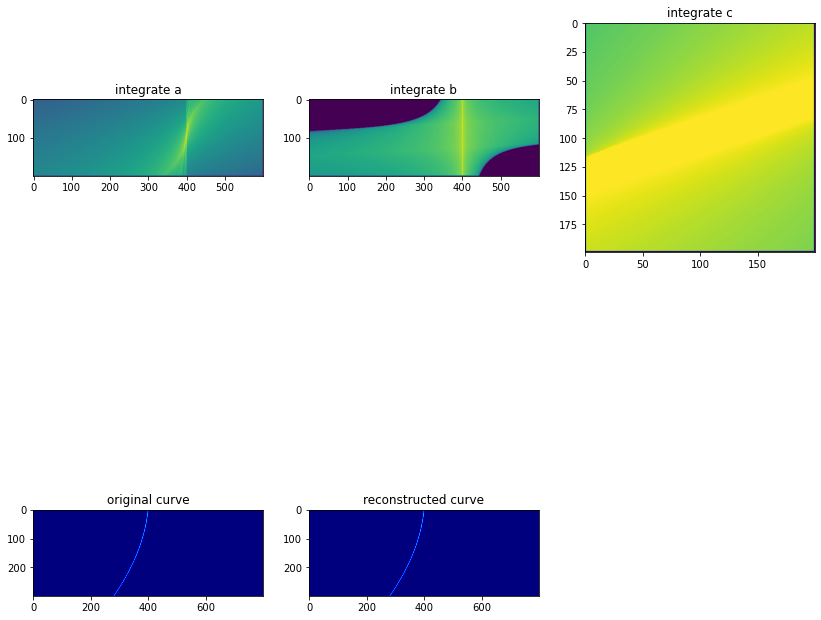

In [1101]:
plt.rcParams["figure.figsize"]=(14, 14)

parab = draw_parab(-.001, -.1, 400, np.zeros_like(orig))
accumulator, aa, bb, cc = hough_curve(parab, a_min = -.02, a_max = .02, b_min = -2., b_max = 2,
                                      c_min = 0, c_max = 600, NN = 200)
# plt.subplot(4, 1, 1)
# plt.imshow(np.log(1 + accumulator.sum(axis = 0)))
# plt.subplot(4, 1, 2)
# plt.imshow(np.log(1 + accumulator.sum(axis = 1)))
# plt.subplot(4, 1, 3)
# plt.imshow(np.log(1 + accumulator.sum(axis = 2)))
# plt.subplot(4, 1, 4)
# plt.imshow(parab)
# accumulator.max()
plt.subplot(2, 3, 1)
plt.title('integrate a')
plt.imshow(np.log(1 + accumulator.sum(axis = 0)))
plt.subplot(2, 3, 2)
plt.title('integrate b')
plt.imshow(np.log(1 + accumulator.sum(axis = 1)))
plt.subplot(2, 3, 3)
plt.title('integrate c')
plt.imshow(np.log(1 + accumulator.sum(axis = 2)))
plt.subplot(2, 3, 4)
plt.title('original curve')
plt.imshow(parab, cmap = 'jet')

# https://stackoverflow.com/questions/5798364/using-numpy-argmax-on-multidimensional-arrays
idx = np.argmax(accumulator)
vxx, vyy, vzz = np.indices(accumulator.shape)
i_a, i_b, i_c = vxx.ravel()[idx], vyy.ravel()[idx], vzz.ravel()[idx]
a, b, c = aa[i_a], bb[i_b], cc[i_c]
assert accumulator.max() == accumulator[i_a, i_b, i_c]
best_fit = draw_parab(a, b, c, np.zeros_like(orig))
plt.subplot(2, 3, 5)
plt.title('reconstructed curve')
plt.imshow(np.log(1 + best_fit), cmap = 'jet')

a, b, c

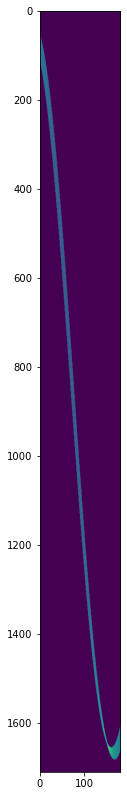

In [1102]:
accumulator_l2, thetas_l, rhos_l = hough_line_2(one_line)
plt.imshow(np.log(1 + accumulator_l2))

(0.0029999999999998604, -0.1999999999999984, 337)

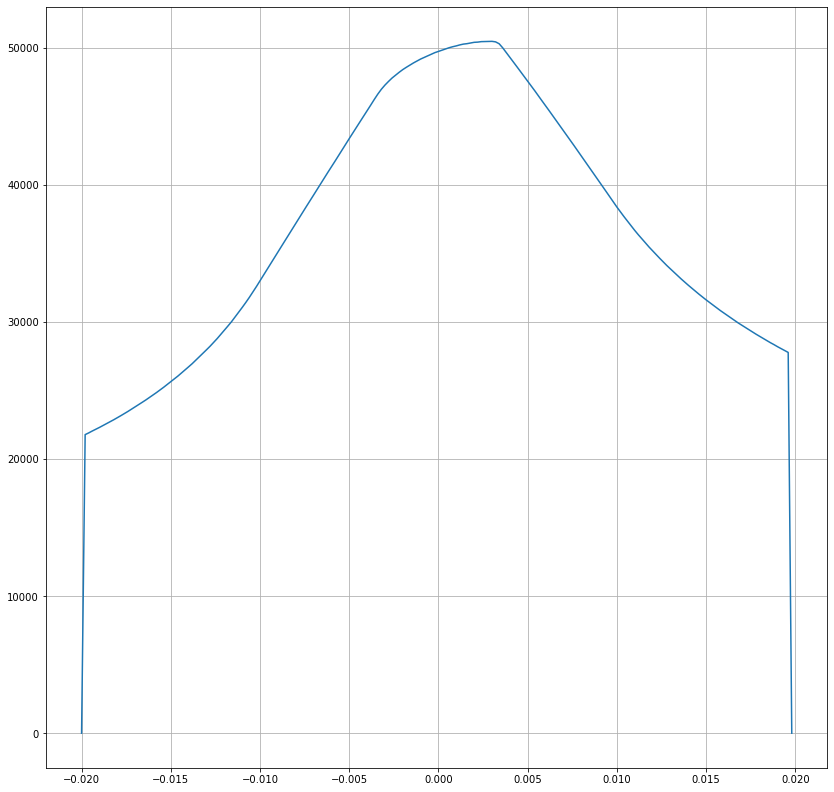

In [1103]:
plt.plot(aa, accumulator.sum(axis = (1, 2)))
plt.grid()
a_center_i = accumulator.sum(axis = (1, 2)).argmax()
from scipy.ndimage.measurements import center_of_mass as cm

b_center_i, c_center_i = np.round(cm(accumulator[a_center_i, :, :])).astype(int)

a, b, c = aa[a_center_i], bb[b_center_i], cc[c_center_i]
a, b, c

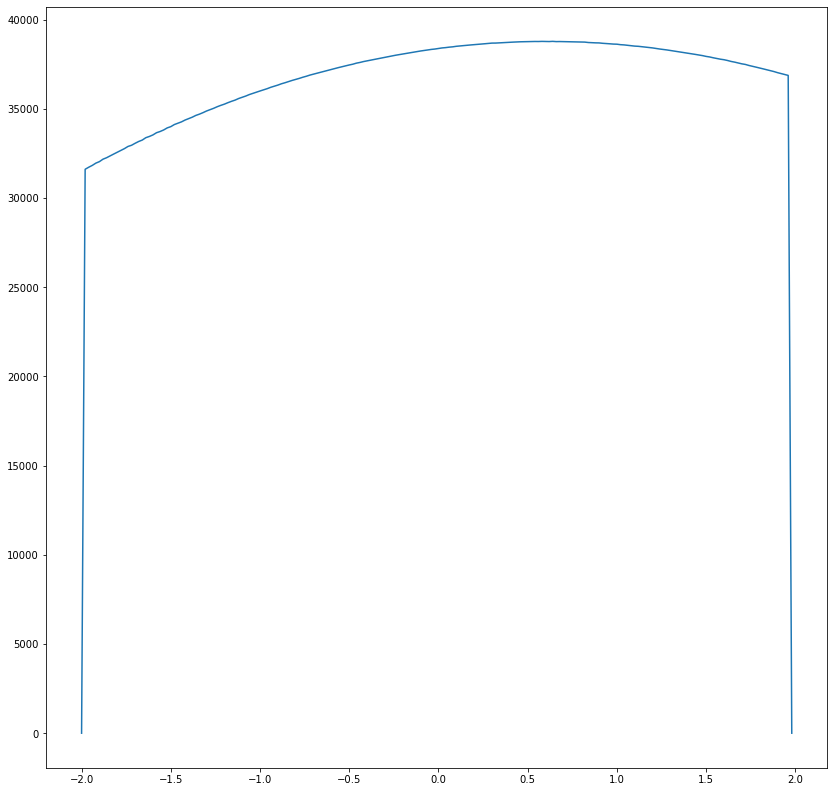

In [1104]:
plt.plot(bb, accumulator.sum(axis = (0, 2)))

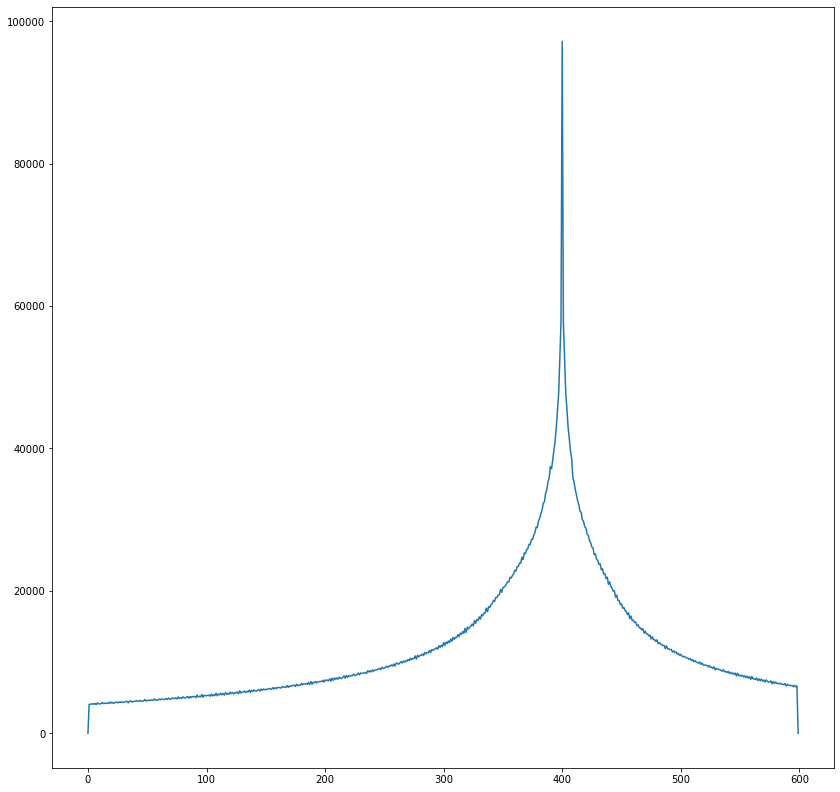

In [1105]:
plt.plot(cc, accumulator.sum(axis = (0, 1)))

In [1160]:
def find_max_indices(accumulator, aa, bb, cc, sum_axis = None):
    if sum_axis is None:
        idx = np.argmax(accumulator)
        dx = np.argmax(accumulator)
        vxx, vyy, vzz = np.indices(accumulator.shape)
        i_a, i_b, i_c = vxx.ravel()[idx], vyy.ravel()[idx], vzz.ravel()[idx]
        return (i_a, i_b, i_c), (aa[i_a], bb[i_b], cc[i_c])
    else:
        accumulator = accumulator.sum(axis = sum_axis)
        dim_dict = {0: [bb, cc], 1: [aa, cc], 2: [aa, bb]}
        dim1, dim2 = dim_dict[sum_axis]
        return fmi_2d(accumulator, dim1, dim2)
    
def fmi_2d(accumulator, val_1, val_2):
    idx = np.argmax(accumulator)
    vxx, vyy = np.indices(accumulator.shape)
    i_a, i_b = vxx.ravel()[idx], vyy.ravel()[idx]
    return (i_a, i_b), (val_1, val_2)

## 3D Hough transform of detected ridges:

(100, 100, 413, -1.214306433183765e-16, 1.7763568394002505e-15, 413)

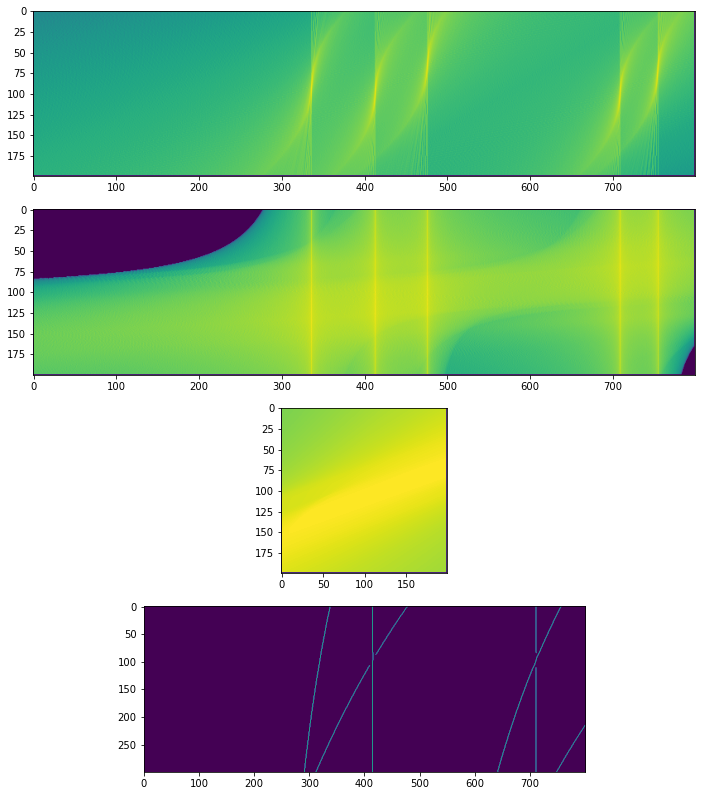

In [1128]:
a, b  = -2.7, 1100
ec = edges.copy()
# N, M = ec.shape
# xx, yy = np.arange(M), np.arange(N)
# vxx, vyy = np.meshgrid(xx, yy)
# mask = vyy < (a * vxx + b)
# ec = mask * ec

accumulator, aa, bb, cc = hough_curve(ec, c_max = 800, NN = 200)

plt.subplot(4, 1, 1)
plt.imshow(np.log(1 + accumulator.sum(axis = 0)))
plt.subplot(4, 1, 2)
plt.imshow(np.log(1 + accumulator.sum(axis = 1)))
plt.subplot(4, 1, 3)
plt.imshow(np.log(1 + accumulator.sum(axis = 2)))
plt.subplot(4, 1, 4)
plt.imshow(ec)

(i_a, i_b, i_c), (a, b, c) = find_max_indices(accumulator, aa, bb, cc)
i_a, i_b, i_c, a, b, c

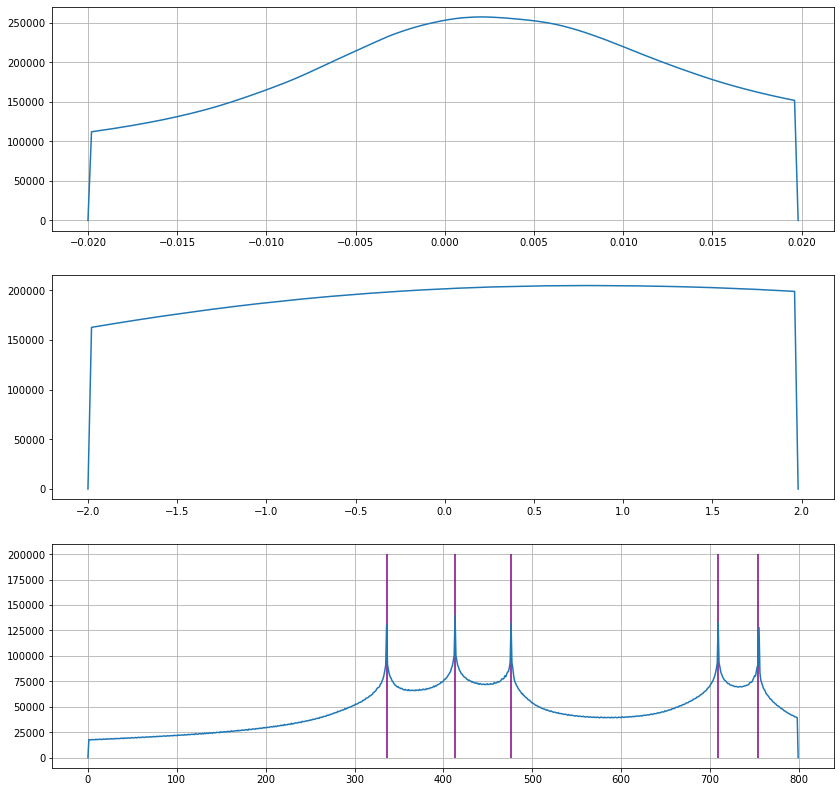

In [1145]:
plt.subplot(3, 1, 1)
plt.plot(aa, accumulator.sum(axis = (1, 2)))
plt.grid()
# a_center_i = accumulator.sum(axis = (1, 2)).argmax()
# from scipy.ndimage.measurements import center_of_mass as cm

# b_center_i, c_center_i = np.round(cm(accumulator[a_center_i, :, :])).astype(int)

# a, b, c = aa[a_center_i], bb[b_center_i], cc[c_center_i]
# a, b, c
plt.subplot(3, 1, 2)
plt.plot(bb, accumulator.sum(axis = (0, 2)))
plt.subplot(3, 1, 3)
curve_c = argrelextrema(gf(accumulator.sum(axis = (0, 1)), 2), np.greater)[0]
plt.vlines(x = curve_c, ymin = 0, ymax = (2e5), 
           colors = 'purple', 
           label = 'vline_multiple - full height') 
curve_c
plt.grid()
plt.plot(cc, accumulator.sum(axis = (0, 1)))

In [1216]:
acurves = accumulator[:, :, curve_c]

c_recon = np.zeros_like(orig)
c_recon = draw_parab(aa[ca], bb[cb], cc[ccc], c_recon)

curves_arrs = []

for i in range(len(curve_c)):
    (ca, cb), (caa, cbb) = fmi_2d(acurves[:, :, i], aa, bb)
    ccc = curve_c[i]
    c_recon = draw_parab(aa[ca], bb[cb], cc[ccc], np.zeros_like(c_recon))
    curves_arrs.append(c_recon)

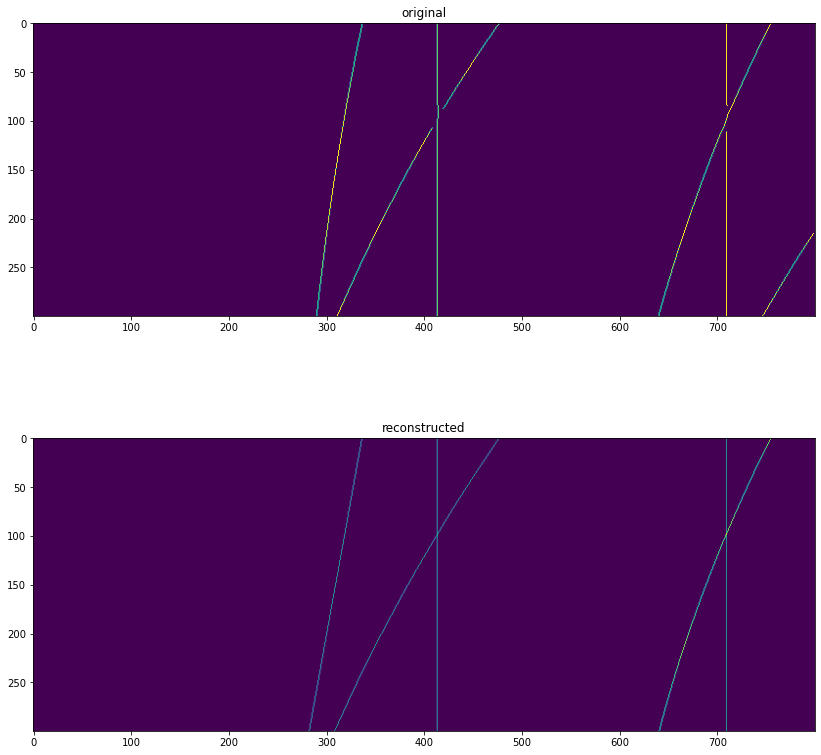

In [1192]:
plt.subplot(2, 1, 1)
plt.title("original")
plt.imshow(np.log(1 + edges))

plt.subplot(2, 1, 2)
plt.title("reconstructed")
plt.imshow(np.log(1 + c_recon))

In [1206]:
# curves_arrs = [acurves[:, :, i] for i in range(len(curve_c))]

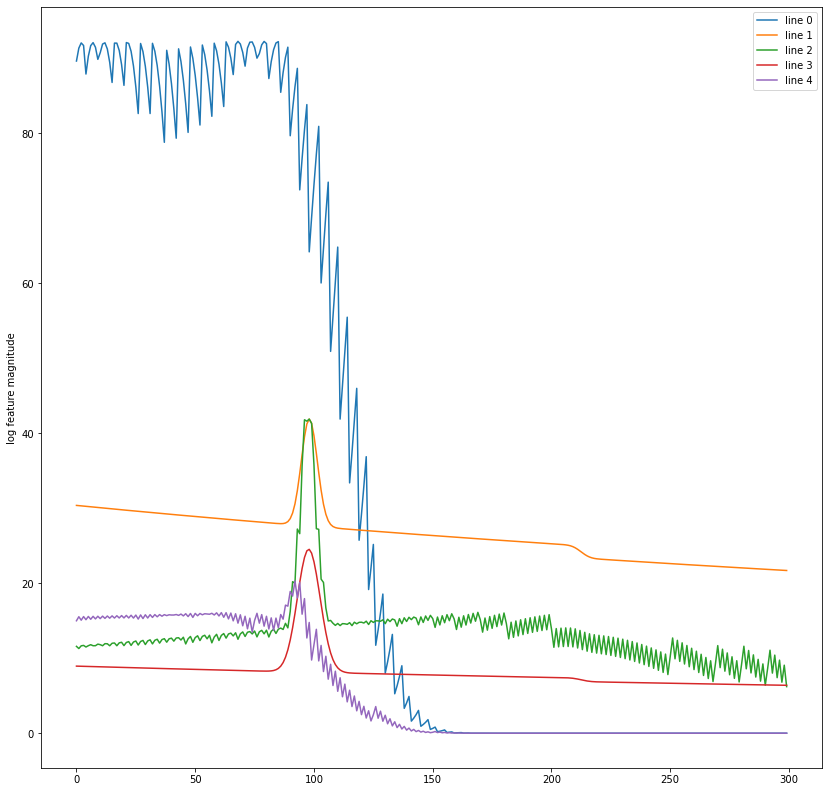

In [1219]:
def row_dp(row, i, refimage):
    return np.dot(refimage[i], row)

def feats_imatch(imatch):
    #print(curves_arrs[0].shape, orig.shape)
    return np.array([row_dp(orig[imatch], imatch, curves_arrs[i]) for i in range(len(curve_c))])

line_feats = np.array([feats_imatch(i) for i in range(len(orig))])
#[plt.plot(np.log(1 + row), label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]
[plt.plot(row, label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]

plt.ylabel('log feature magnitude')
plt.legend()

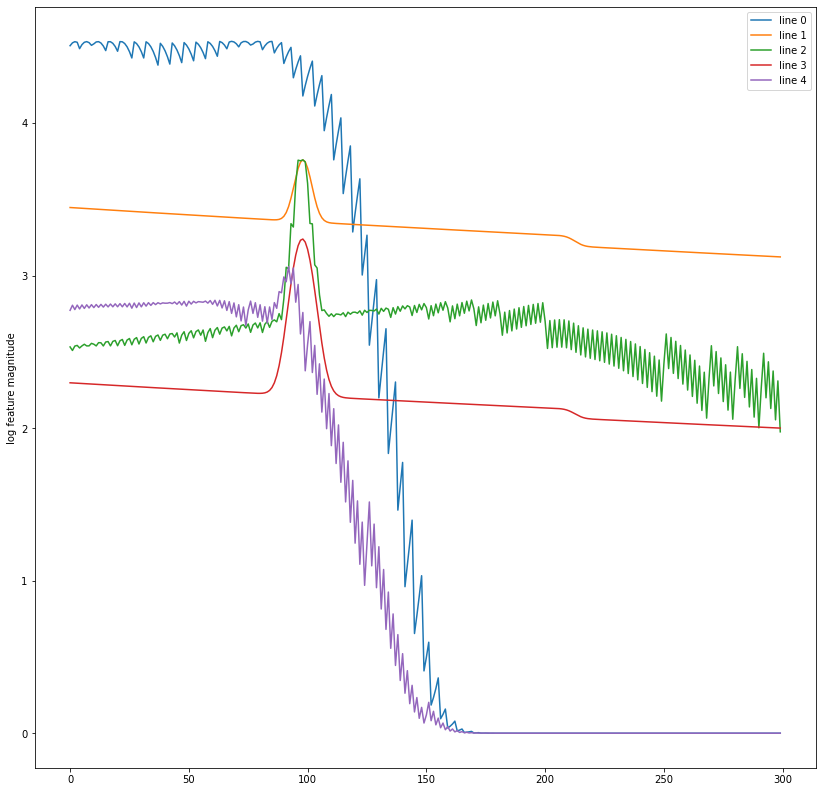

In [1218]:
def row_dp(row, i, refimage):
    return np.dot(refimage[i], row)

def feats_imatch(imatch):
    #print(curves_arrs[0].shape, orig.shape)
    return np.array([row_dp(orig[imatch], imatch, curves_arrs[i]) for i in range(len(curve_c))])

line_feats = np.array([feats_imatch(i) for i in range(len(orig))])
#[plt.plot(np.log(1 + row), label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]
[plt.plot(row, label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]

plt.ylabel('log feature magnitude')
plt.legend()

Old for reference

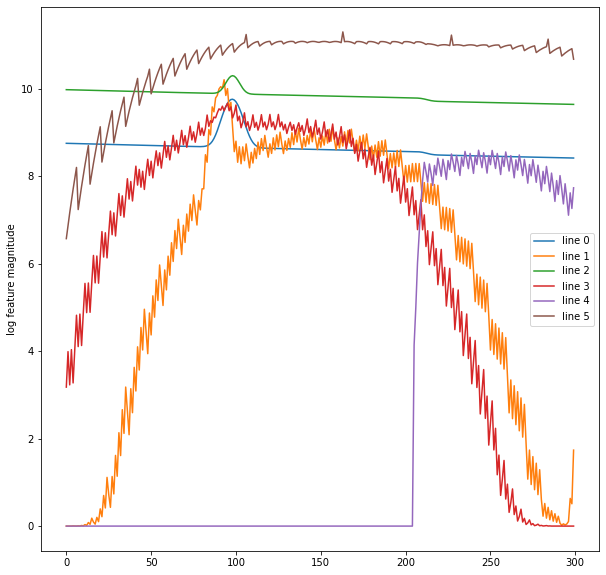

In [1209]:
feats_imatch

<function __main__.feats_imatch(imatch)>

In [1207]:
[plt.plot(np.log(1 + row), label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]
plt.ylabel('log feature magnitude')
plt.legend()

NameError: name 'line_feats' is not defined

(100, 100, 709, -1.214306433183765e-16, 1.7763568394002505e-15, 709)

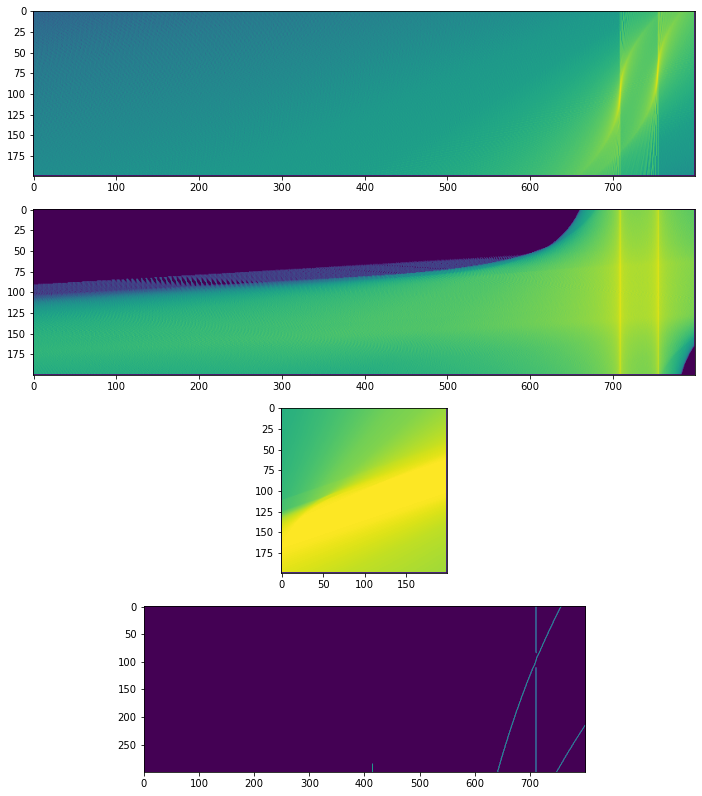

In [1127]:
a, b  = -2.7, 1400
ec = edges.copy()

N, M = ec.shape
xx, yy = np.arange(M), np.arange(N)
vxx, vyy = np.meshgrid(xx, yy)
mask = vyy > (a * vxx + b)
ec = mask * ec

accumulator, aa, bb, cc = hough_curve(ec, a_min = -.02, a_max = .02, b_min = -2., b_max = 2,
                                      c_min = 0, c_max = 800, NN = 200)

plt.subplot(4, 1, 1)
plt.imshow(np.log(1 + accumulator.sum(axis = 0)))
plt.subplot(4, 1, 2)
plt.imshow(np.log(1 + accumulator.sum(axis = 1)))
plt.subplot(4, 1, 3)
plt.imshow(np.log(1 + accumulator.sum(axis = 2)))
plt.subplot(4, 1, 4)
plt.imshow(ec)

(i_a, i_b, i_c), (a, b, c) = find_max_indices(accumulator, aa, bb, cc)
i_a, i_b, i_c, a, b, c

In [1121]:
max_ind = argrelextrema(orig, np.greater, axis = 1)

(100, 100, 413)

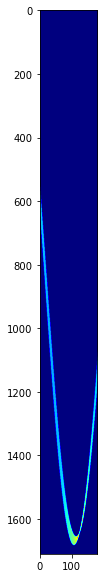

In [165]:
plt.imshow(np.log( 1 + accumulator_l), cmap = 'jet')

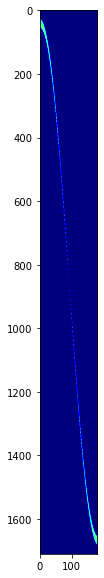

In [166]:
plt.imshow(np.log( 1 + accumulator), cmap = 'jet')

In [268]:
idx = np.argmax(accumulator)
rho = rhos[idx // accumulator.shape[1]]
theta = thetas[idx % accumulator.shape[1]]
print ("rho={0:.2f}, theta={1:.0f}".format(rho, np.rad2deg(theta)))

IndexError: index 54 is out of bounds for axis 0 with size 20

In [76]:
accum.shape, thetas.shape, rhos.shape

((1710, 180), (180,), (1710,))

[]

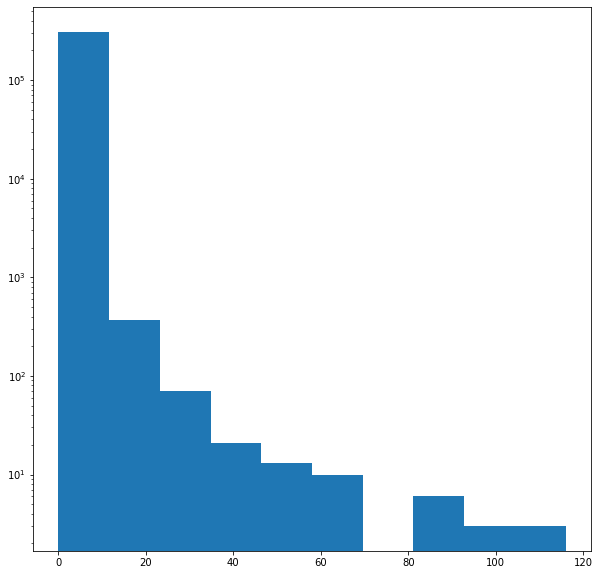

In [109]:
plt.hist(accum.ravel())
plt.semilogy()

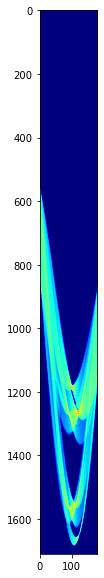

In [111]:
# plt.subplot(2, 1, 1)
plt.imshow(np.log(1 + accumulator), cmap = 'jet')
#plt.imshow(accum)

In [85]:
# image = np.zeros((50,50))
# image[10:40, 10:40] = np.eye(30)
# accumulator, thetas, rhos = hough_line(image)

# # Easiest peak finding based on max votes
# idx = np.argmax(accumulator)
# rho = rhos[idx // accumulator.shape[1]]
# theta = thetas[idx % accumulator.shape[1]]
# print( "rho={0:.2f}, theta={1:.0f}".format(rho, np.rad2deg(theta)))

71.0
rho=0.50, theta=-45


In [424]:
#lines = cv2.HoughLines(edges,1,np.pi/45,70)
lines_img = np.zeros_like(img)

lines_arrs = [np.zeros_like(img) for i in range(len(lines_merged))]

def line_points(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    return x1, y1, x2, y2

for i, row in enumerate(lines_merged[:, None]):
    for rho,theta in row:
        x1, y1, x2, y2 = line_points(rho, theta)

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.line(lines_img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.line(lines_arrs[i],(x1,y1),(x2,y2),(0,0,255),2)

In [1113]:
def get_line_coords(rho, theta, arr):
    """
    return x, y coord arrays
    """
    N, M = arr.shape
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = round(a * rho)
    y0 = round(b * rho)
    extend_x = N - x0
    extend_y = M - y0
    x = np.arange(N)
    y = -a * np.arange(-x0, extend_x) + y0
    return x, y

# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
import numpy as np
from scipy.signal import argrelextrema


# determine the indices of the local maxima
max_ind = argrelextrema(orig, np.greater, axis = 1)

1540.0

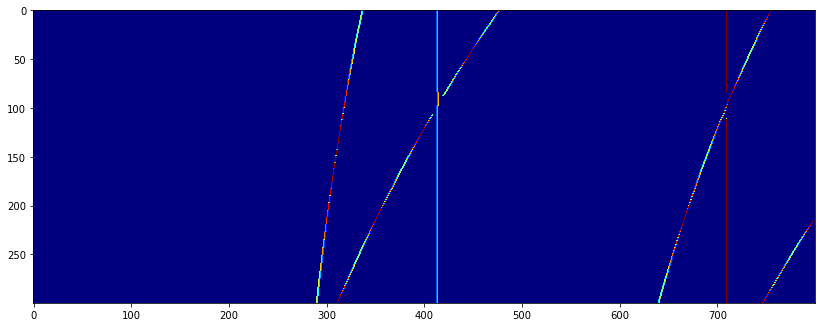

In [1114]:
edges = np.zeros_like(orig)
edges[max_ind] = 1
plt.imshow(edges, cmap = 'jet')
edges.sum()

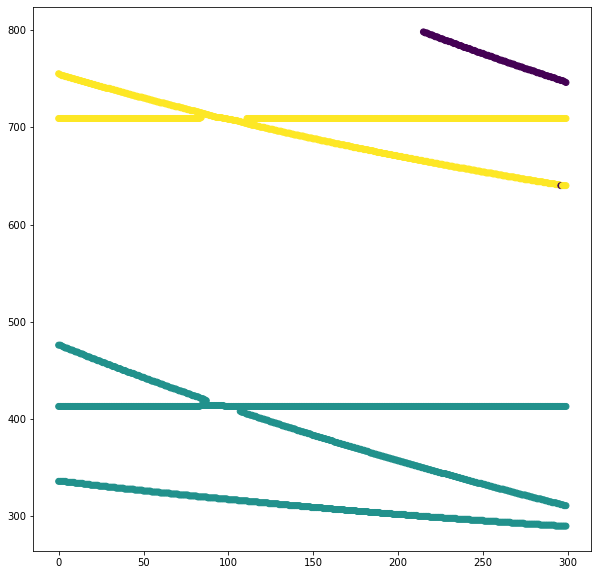

In [1098]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.1)#, cluster_method='dbscan', eps = None)
X = np.vstack(np.nonzero(tmp)).T

clust.fit(X)
plt.scatter(*(X.T), c = clust.labels_)

In [1006]:
%matplotlib inline

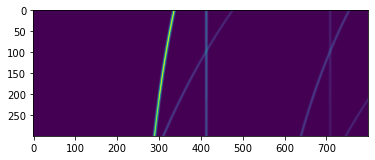

In [1007]:
plt.imshow(orig)

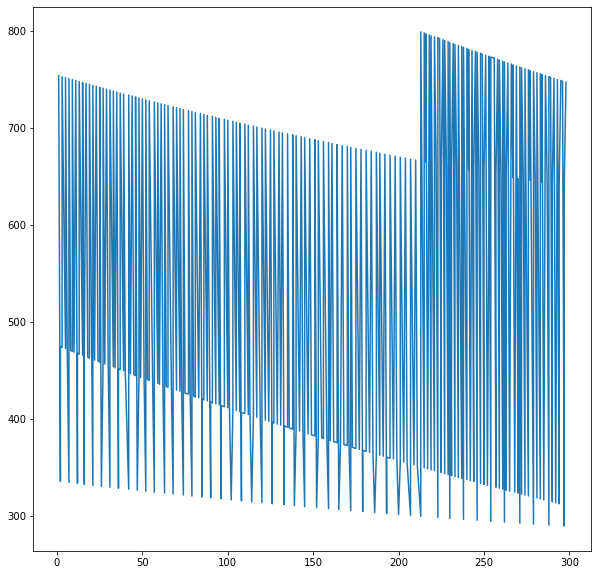

In [302]:
get_line_coords()

In [321]:
xpeak, ypeak = argrelextrema(orig, np.greater, axis = 1)

In [326]:
x, y = get_line_coords(lines_merged[-1][0], lines_merged[-1][1], orig)

TypeError: get_line_coords() missing 3 required positional arguments: 'rho', 'theta', and 'arr'

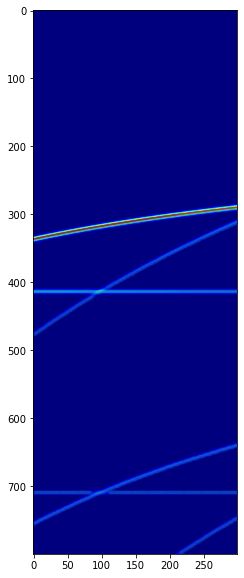

In [320]:
plt.imshow(orig.T, cmap = 'jet')
plt.scatter(*argrelextrema(orig, np.greater, axis = 1), alpha = .1, s = 10)

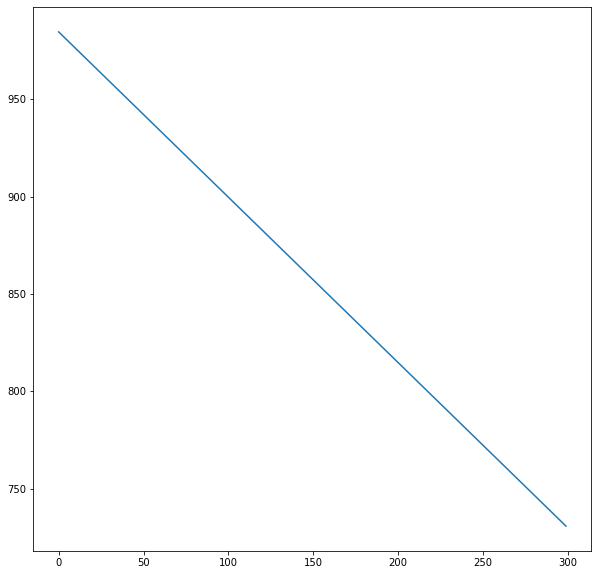

In [296]:
plt.plot(*get_line_coords(lines_merged[-1][0], lines_merged[-1][1], orig))

In [ ]:
lines_norm

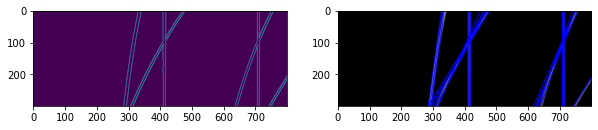

In [270]:
#plt.imshow(np.array(gray))
plt.subplot(1, 2, 1)
plt.imshow(np.array(edges))
plt.subplot(1, 2, 2)
plt.imshow(np.array(img))
#plt.imshow(lines_img)

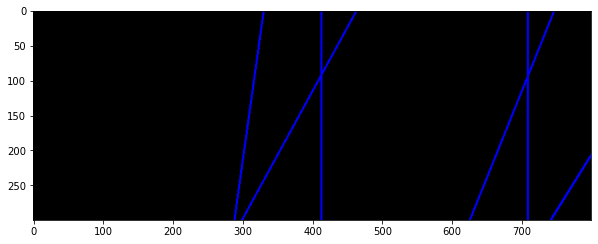

In [271]:
plt.imshow(np.array(lines_img))


In [272]:
lines

array([[[7.0600000e+02, 0.0000000e+00]],

       [[4.1700000e+02, 0.0000000e+00]],

       [[7.1300000e+02, 0.0000000e+00]],

       [[4.0900000e+02, 0.0000000e+00]],

       [[3.3200000e+02, 1.3962634e-01]],

       [[3.2300000e+02, 1.3962634e-01]],

       [[4.0600000e+02, 4.8869219e-01]],

       [[4.0500000e+02, 5.5850536e-01]],

       [[4.1300000e+02, 4.8869219e-01]],

       [[7.0200000e+02, 3.4906584e-01]],

       [[6.9100000e+02, 4.1887903e-01]],

       [[3.9900000e+02, 5.5850536e-01]],

       [[4.0900000e+02, 4.1887903e-01]],

       [[6.9500000e+02, 3.4906584e-01]],

       [[6.8400000e+02, 4.1887903e-01]],

       [[7.8800000e+02, 5.5850536e-01]]], dtype=float32)

In [767]:
from scipy.signal import convolve2d

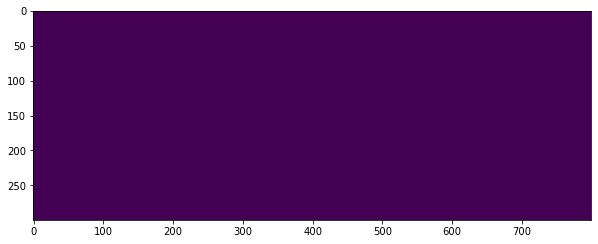

In [112]:
plt.imshow(lines_img.sum(axis = 2))

In [1196]:
def row_dp(row, i, refimage):
    return np.dot(refimage[i], row)

In [783]:
c2d = convolve2d(lines_img.sum(axis = 2), Ni_scan[0][:, None])

In [798]:
query = orig[150]
match_curve = np.array([np.dot(r, query) for r in lines_img.sum(axis = 2)])

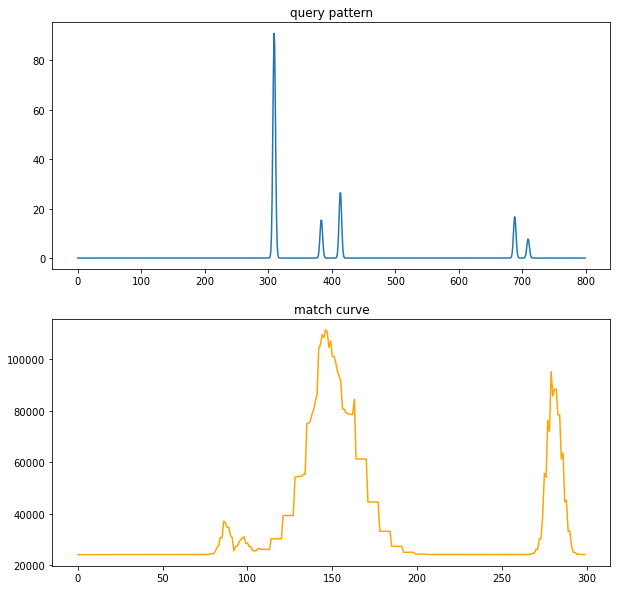

In [863]:
imatch = np.argmax(match_curve)
match = orig[imatch]
plt.subplot(2, 1, 1)
plt.title('query pattern')
plt.plot(query)

plt.subplot(2, 1, 2)
plt.title('match curve')
plt.plot(match_curve, c = 'orange')
# plt.plot(match)

In [818]:
def row_dp(row, i, refimage):
    return np.dot(refimage[i], row)
def feats_imatch(imatch):
    return np.array([row_dp(orig[imatch], imatch, lines_arrs[i].sum(axis = 2)) for i in range(len(lines_merged))])

line_feats = np.array([feats_imatch(i) for i in range(len(orig))])

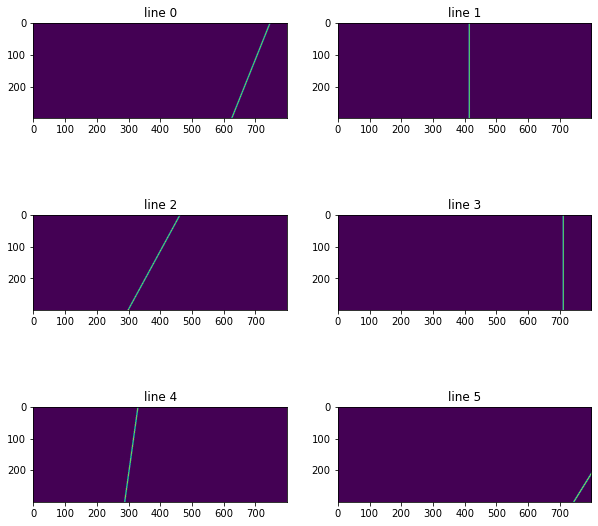

In [425]:
for i in range(len(lines_merged)):
    plt.subplot(3, 2, i + 1)
    plt.title('line {}'.format(i))
    plt.imshow(lines_arrs[i].sum(axis = 2))

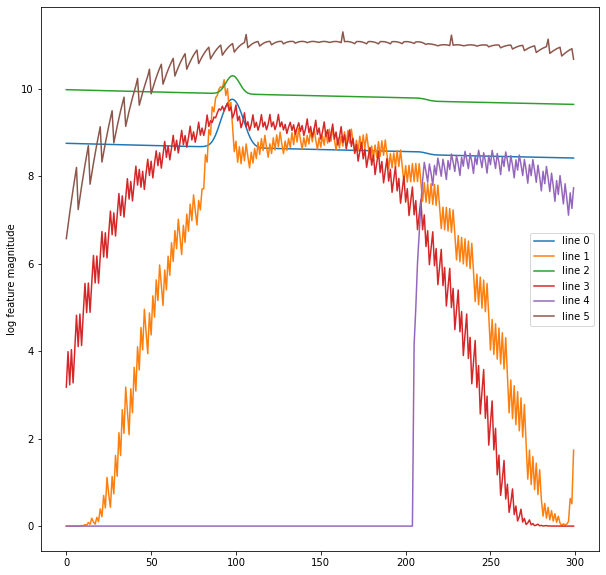

In [837]:
[plt.plot(np.log(1 + row), label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]
plt.ylabel('log feature magnitude')
plt.legend()

In [765]:
cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[10]).shape

(300, 800)

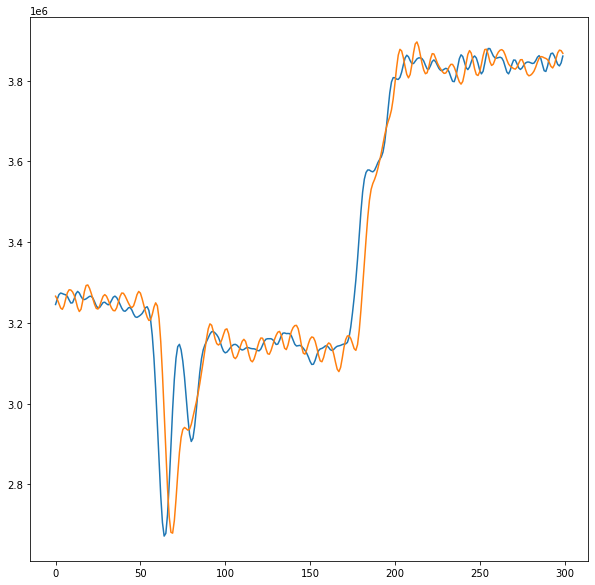

In [764]:
plt.plot(cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[10]).sum(axis = 1))
plt.plot(cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[20]).sum(axis = 1))

In [15]:
from importlib import reload
reload(xdu)
reload(grid_data)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [ ]:
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=500, maxRadius=10000)
# # Draw detected circles
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for i in circles[0, :]:
#         # Draw outer circle
#         cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
#         # Draw inner circle
#         cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

# alg = cv2.GeneralizedHoughGuil()
# # Simple create template with 1 channel black images with size 5x5
# template = np.zeros((5,5))
# alg.setTemplate(template)

# import cv2
# alg = cv2.createGeneralizedHoughGuil()
# alg.setMinDist(40)
# alg.setLevels(40)

In [13]:
qq, ii = xdu.mk_pattern(i, q, .01, with_grid=True)

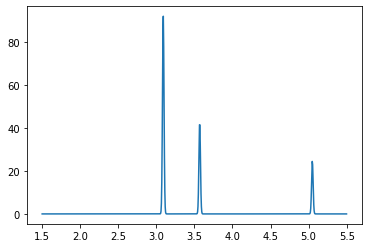

In [14]:
plt.plot(qq, ii)

## Cubic to tetragonal transition:

In [23]:
sigma = .01
q_cubic, i_cubic = distort_Ni(1)
cubic_patterns = np.vstack([xdu.mk_pattern(i_cubic, q_cubic, sigma, with_grid = False)
                           for _ in range(200)])

_, cubic_to_tetra_continuous = Ni_cubic_to_tetra(200, 1, 1.2, sigma = sigma)

In [24]:
from importlib import reload
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [25]:
q_tetra, i_tetra = distort_Ni(1.2)
cubic_to_tetra_twophase = simulation.transition(1, 1, (q, i), (q_tetra, i_tetra), 200, sigma = sigma,
                                                scale_type = 'scale')[::-1]

In [26]:
X = np.vstack((cubic_to_tetra_twophase, cubic_patterns, cubic_to_tetra_continuous))
#X = np.log(1 + np.vstack((cubic_to_tetra_twophase, cubic_patterns, cubic_to_tetra_continuous)))

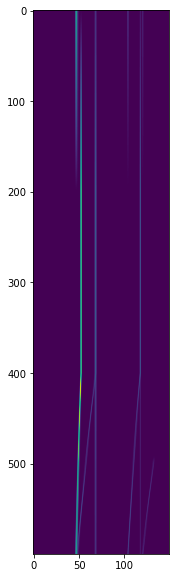

In [585]:
plt.imshow(Ni_X)

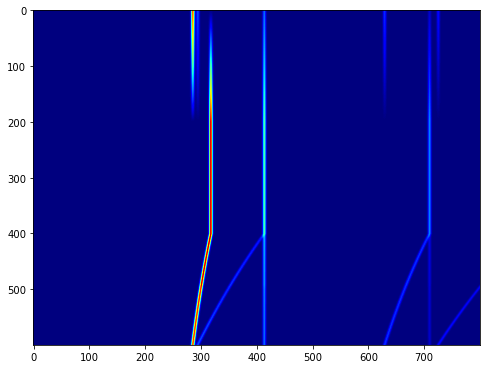

In [43]:
plt.imshow(X, cmap = 'jet')

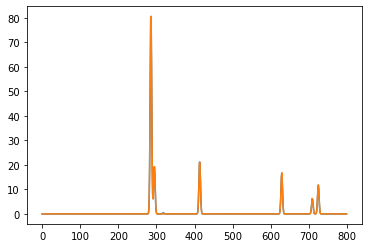

In [28]:
plt.plot(X[0])
plt.plot(X[-1])

In [307]:
Ni_XX, Ni_YY = simulation.sample_transition(X, n_classes = 30, per_class = 200, scale_min = .8, scale_max = 1.2,
                                            scale_type = 'scale')

scale type: scale
q jitter: None
peak height variation True


In [79]:
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [436]:
Ni_X, Ni_Y = xdu.standardize_input(X, np.arange(len(X)) // 200)

In [229]:
Ni_XX.mean()

1.0

In [230]:
prefix="Ni_cubic_to_tetra"
xdu.write_train_test("data/{}/".format(prefix), Ni_XX, Ni_YY,
                 Ni_XX,\
                 Ni_YY // 10)

In [231]:
runout_Ni_transition =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = 30, epochs = 200)

  0%|          | 0/37600 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 37600/37600 [07:50<00:00, 79.84it/s, epoch=199, train_loss=0.0353, val_loss=0.0353] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-*


Legend:

- blue: tetragonal to cubic (discontinuous)
- orange: cubic
- green: cubic to tetragonal (continuous)

siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-testing-set-embedding.png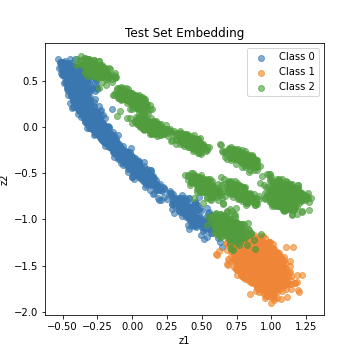

In [271]:
X.shape

(600, 800)

In [29]:
Ni_XX, Ni_YY = simulation.sample_transition(X, n_classes = 3, per_class = 400, scale_min = .8, scale_max = 1.2,
                                            scale_type = 'scale')

#Ni_XX, Ni_YY = xdu.standardize_input(np.log(1 + X), Ni_Y)

scale type: scale
q jitter: None
peak height variation True


In [30]:
Ni_transition_loader = xd.ndarr_to_dataloader(Ni_XX, Ni_YY)

In [241]:
reload(xd)

<module 'xrdc.datasets' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/datasets.py'>

In [1023]:
plt.rcParams["figure.figsize"]=(10, 10)

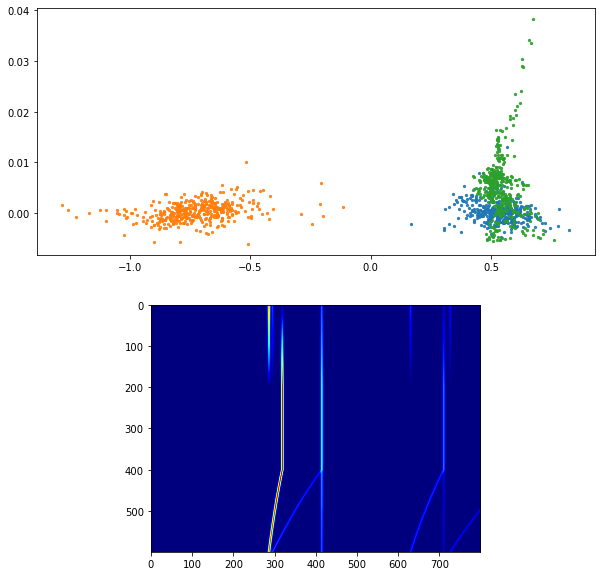

In [85]:
plt.subplot(2, 1, 1)

transition_X, transition_ytrue = utils.get_embedding(net, Ni_transition_loader)

#pca2, transition_Xpca = vis.do_pca(transition_X)
#transition_Xpca, ypred = xdu.gcluster(transition_X, N = 3)

transition_Xpca = pca.transform(transition_X)

#plt.scatter(*(transition_Xpca.T), c = ypred, s = 20, alpha = .3, cmap = 'jet')
for c in range(3):
    plt.scatter(*(((transition_Xpca)[(transition_ytrue == c).squeeze()]).T), s = 5, alpha = .9, cmap = 'jet')
#plt.scatter(*(transition_Xpca.T), c = transition_ytrue, s = 20, alpha = .5, cmap = 'jet')


#plt.scatter(*(Xpca.T), c = ytrue, s = 30, alpha = .5)
#plt.scatter(*(Xpca.T), s = 30, alpha = .5)

plt.subplot(2, 1, 2)
plt.imshow(X, cmap = 'jet')

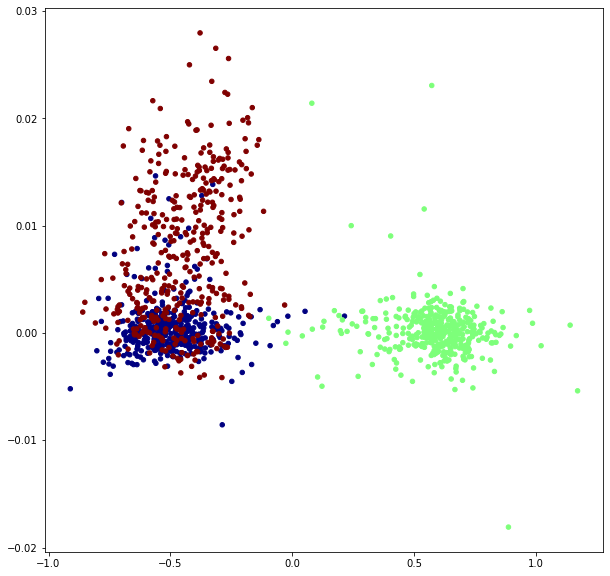

In [484]:
transition_X, transition_ytrue = utils.get_embedding(net, Ni_transition_loader)

#_, transition_Xpca = vis.do_pca(transition_X)

transition_Xpca = pca.transform(transition_X)
plt.scatter(*(transition_Xpca.T), c = transition_ytrue, s = 20, alpha = 1, cmap = 'jet')
#plt.scatter(*(Xpca.T), c = ytrue, s = 30, alpha = .5)
#plt.scatter(*(Xpca.T), s = 30, alpha = .5)